In [1]:
# libraries
# %matplotlib notebook
import os
import pandas as pd
import numpy as np
import json
import itertools
import matplotlib
import matplotlib.dates as md
import time
import datetime
from matplotlib import pyplot as plt
import torch as torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler

<span style="font-size: 36px;"> ---------------</span>


<span style="font-size: 36px;"> **Data Visualisation**</span>


<span style="font-size: 36px;"> ---------------</span>

In [2]:
data = {}
path = './../NAB/data/'

def addFolderAndReadAll(f_name):
    data[f_name] = {}
    csvs = os.listdir(path + '/' + f_name)
    csvs_num = 0
    for csv in csvs:
        data[f_name][csv] = pd.read_csv(path + '/' + f_name + '/' + csv)
        csvs_num += 1
    return csvs_num

csvs_num = sum([addFolderAndReadAll(f_name) for f_name in os.listdir(path) if os.path.isdir(path + f_name)])

In [3]:
data['artificialWithAnomaly']['art_daily_nojump.csv']

timestamp      value
0     2014-04-01 00:00:00  21.598011
1     2014-04-01 00:05:00  19.321392
2     2014-04-01 00:10:00  21.399938
3     2014-04-01 00:15:00  18.373916
4     2014-04-01 00:20:00  18.167499
...                   ...        ...
4027  2014-04-14 23:35:00  18.379705
4028  2014-04-14 23:40:00  19.383839
4029  2014-04-14 23:45:00  21.423756
4030  2014-04-14 23:50:00  21.851140
4031  2014-04-14 23:55:00  18.969085

[4032 rows x 2 columns]

In [4]:
with open('./../NAB/labels/combined_windows.json', 'r') as file:
    labels = json.load(file)

In [5]:
for tt in data:
    print(tt)
        
    print('---')
    for tt2 in data[tt]:
        print(tt2)
        
    print('---')
    

realAdExchange
---
exchange-4_cpm_results.csv
exchange-2_cpc_results.csv
exchange-3_cpm_results.csv
exchange-3_cpc_results.csv
exchange-4_cpc_results.csv
exchange-2_cpm_results.csv
---
realTraffic
---
TravelTime_387.csv
occupancy_6005.csv
speed_t4013.csv
speed_6005.csv
occupancy_t4013.csv
TravelTime_451.csv
speed_7578.csv
---
artificialNoAnomaly
---
art_flatline.csv
art_daily_no_noise.csv
art_noisy.csv
art_daily_perfect_square_wave.csv
art_daily_small_noise.csv
---
artificialWithAnomaly
---
art_daily_nojump.csv
art_daily_jumpsdown.csv
art_daily_flatmiddle.csv
art_load_balancer_spikes.csv
art_daily_jumpsup.csv
art_increase_spike_density.csv
---
realTweets
---
Twitter_volume_CVS.csv
Twitter_volume_KO.csv
Twitter_volume_AAPL.csv
Twitter_volume_GOOG.csv
Twitter_volume_CRM.csv
Twitter_volume_UPS.csv
Twitter_volume_FB.csv
Twitter_volume_IBM.csv
Twitter_volume_AMZN.csv
Twitter_volume_PFE.csv
---
realAWSCloudwatch
---
ec2_network_in_257a54.csv
ec2_cpu_utilization_fe7f93.csv
iio_us-east-1_i-a2e

In [7]:
for key1 in data:
    for key2 in data[key1]:
        one_csv_labels = labels[key1 + '/' + key2]

        # Create an anomaly column initialized to 0 (no anomaly)
        data[key1][key2]['anomaly'] = 0

        for interval in one_csv_labels:
            # Using pandas to directly get the indices
            index1 = data[key1][key2][data[key1][key2]['timestamp'] == interval[0][:19]].index[0]
            index2 = data[key1][key2][data[key1][key2]['timestamp'] == interval[1][:19]].index[0]

            # Mark rows as anomalous
            data[key1][key2].loc[index1:index2, 'anomaly'] = 1


In [8]:
data['realTweets']['Twitter_volume_GOOG.csv'].columns

Index(['timestamp', 'value', 'interval', 'anomaly'], dtype='object')

In [10]:
data[key1][key2]['labels'] = np.zeros(np.shape(data[key1][key2]['interval']))
for i in data[key1][key2]['interval']:
    if isinstance(i, slice):
        data[key1][key2]['labels'][i] = 1
    else:
        break

/tmp/ipykernel_160065/1100460689.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[key1][key2]['labels'][i] = 1


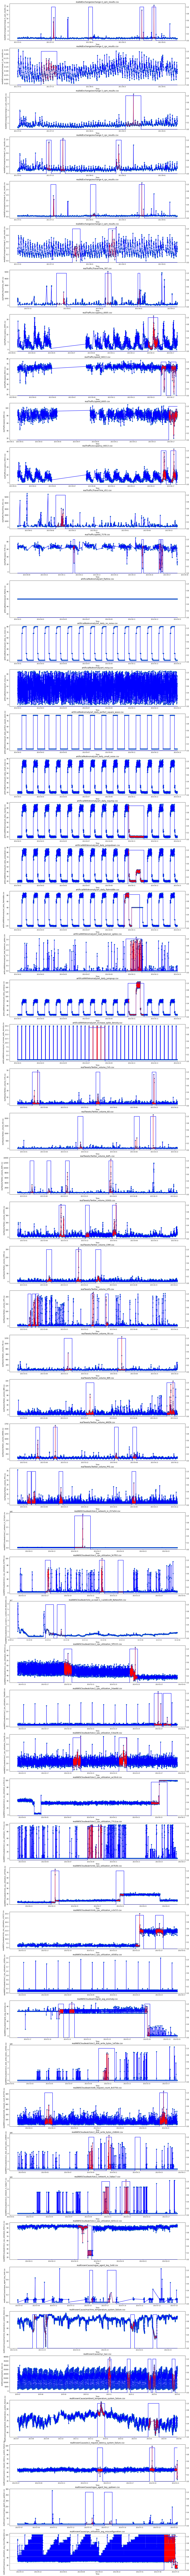

In [11]:
fig = plt.figure(figsize=(20, 300))

num = 0
for key1 in data:
    for key2 in data[key1]:
        num += 1      
        
        y = data[key1][key2]['value']
        x = pd.to_datetime(data[key1][key2]['timestamp'])
        
        ax = fig.add_subplot(csvs_num,1,num)
        
        ax.title.set_text(key1+'/'+key2)
        ax.set_xlabel('Time')
        ax.set_ylabel(key1+'/'+key2)
        plt.setp(ax.get_xticklabels(), size=8)
        ax.plot(x, y, 'b-', linewidth=2)
        
        ax2 = ax.twinx()
        yi = data[key1][key2]['anomaly']
        ax2.plot(x, yi, 'b-', linewidth=2)
        ax2.set_ylim(0,1.1)
        i = 0
        
        while data[key1][key2]['interval'][i] != 0:
            bold = data[key1][key2]['interval'][i]
            ax.plot(x[bold], y[bold], 'r-', linewidth=1)
            i += 1
        ax.scatter(x, y)

plt.grid()
plt.show()

<span style="font-size: 36px;"> ---------------</span>


<span style="font-size: 36px;"> **DATA PROCESS**</span>


<span style="font-size: 36px;"> ---------------</span>

In [13]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import time

class FFTTimeSeriesPreprocessor:
    
    def __init__(self, dataframe):
        self.data = dataframe.copy()
        self.timestamp_col = self.data.columns[0]
        self.value_col = self.data.columns[1]
        
    def handle_missing_values(self, strategy="mean"):
        self.data['validity_flag'] = 1
        self.data.loc[self.data[self.value_col].isnull(), 'validity_flag'] = 0

        if strategy == "drop":
            self.data.dropna(inplace=True)
        elif strategy == "mean":
            self.data[self.value_col].fillna(self.data[self.value_col].mean(), inplace=True)
        elif strategy == "ffill":
            self.data.fillna(method="ffill", inplace=True)
        elif strategy == "bfill":
            self.data.fillna(method="bfill", inplace=True)
        else:
            raise ValueError("Invalid strategy selected for handling missing values.")
            
    def convert_to_datetime(self):
        self.data[self.timestamp_col] = pd.to_datetime(self.data[self.timestamp_col]).apply(lambda x: time.mktime(x.timetuple()))
        
    def resample_data(self, frequency):
        self.data.set_index(self.timestamp_col, inplace=True)
        self.data = self.data.resample(frequency).ffill()
        
    def normalize_data(self):
        scaler = StandardScaler()
        self.data[f"{self.value_col}"] = scaler.fit_transform(self.data[[self.value_col]])
        
    def fft_features(self):
        # Compute FFT and extract magnitude
        fft_values = np.fft.fft(self.data[self.value_col])
        self.data['fft_magnitude'] = np.abs(fft_values)
        
        # Extract phase
        self.data['fft_phase'] = np.angle(fft_values)
        
        # If you want more frequency domain features, you can add them here.

    def preprocess(self):
        self.handle_missing_values()
        self.convert_to_datetime()
        # Uncomment the below line if you need to resample
        # self.resample_data('5T')
        self.normalize_data()
        self.fft_features()
        
    def get_preprocessed_data(self):
        return self.data


<span style="font-size: 36px;"> ---------------</span>


<span style="font-size: 36px;"> **Prototype Model**</span>


<span style="font-size: 36px;"> ---------------</span>

In [16]:
# Lists to collect the data
train_features = []
train_labels = []
test_features = []
test_labels = []

# Counter to determine whether to add to train or test
num = 0


for key1 in data:
    for key2 in data[key1]:
        #keep count of cummalative addition
        num += 1
        
        # process data
        
        # interval is no longer usefull
        df = data[key1][key2].drop(columns='interval')
        
        preprocessor = FFTTimeSeriesPreprocessor(df)
        preprocessor.preprocess()
        df = preprocessor.get_preprocessed_data()
        # Splitting the data into training and test sets
        split_idx = int(len(df) / 2)
        
        # Apply the splitting
        train_df, test_df = df.iloc[:split_idx], df.iloc[split_idx:]
        
        # Convert individual timestamp to UNIX

        ## Drop anomaly cause no need
        
        # Splitting features and labels for training set
        train_labels.append(train_df['anomaly'].values.tolist())
        train_features.append(train_df.drop(columns=['anomaly','validity_flag']).values.tolist())

        # Splitting features and labels for test set
        test_labels.append(test_df['anomaly'].values.tolist())
        test_features.append(test_df.drop(columns=['anomaly','validity_flag']).values.tolist())

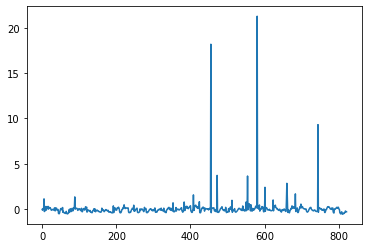

In [20]:
plt.plot(np.array(test_features[0])[:,1])

In [102]:

def set_assigner(train_features,test_features,train_labels,test_labels):
    # tag is the `num` or element from the sets to pick and convert data to tensors
    
    # Convert list of Series to numpy array
    train_features_array = np.stack(train_features).astype(np.float32)
    test_features_array = np.stack(test_features).astype(np.float32)

    # Convert numpy arrays to PyTorch tensors
    train_feature_tensor = torch.from_numpy(train_features_array)
    test_feature_tensor = torch.from_numpy(test_features_array)
    
    # Convert list of Series to numpy array
    train_labels_array = np.stack(train_labels).astype(np.float32)
    test_labels_array  = np.stack(test_labels).astype(np.float32)

    # Convert numpy arrays to PyTorch tensors
    train_labels_tensor = torch.from_numpy(train_labels_array)
    test_labels_tensor = torch.from_numpy(test_labels_array)
    return train_features_array,test_features_array,train_labels_array,test_labels_array


(7951, 4) (7951,)


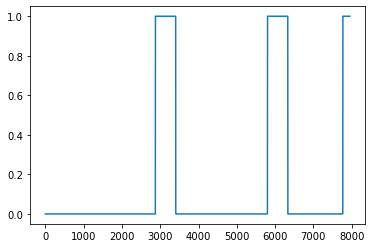

In [129]:
tag = 28
train_feature,test_feature,train_label,test_label = \
    set_assigner(train_features[tag],test_features[tag],train_labels[tag],test_labels[tag])

print(np.shape(train_feature),np.shape(train_label))
plt.plot(train_label)

In [104]:
train_feature[222]

array([1.4250464e+09, 3.5843834e-01, 2.7157962e-01, 6.1588764e-01],
      dtype=float32)

In [133]:
import catboost
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Assuming your data is in train_feature and train_label
X_train, X_val, y_train, y_val = train_test_split(train_feature, train_label, test_size=0.2)


model = CatBoostClassifier(iterations=1000,
                           learning_rate=0.01,
                           depth=6,
                           loss_function='Logloss', # this is the log loss function suitable for binary classification
                           verbose=100,
                           eval_metric='AUC', # this metric is suitable for binary classification
                           early_stopping_rounds=55)

# Train the model
model.fit(X_train, y_train, eval_set=(X_val, y_val))

# Predict and evaluate
predictions = model.predict(X_val)
mse = mean_squared_error(y_val, predictions)

print(f"Validation MSE: {mse:.4f}")


0:	test: 0.9434180	best: 0.9434180 (0)	total: 2.43ms	remaining: 2.43s
100:	test: 0.9998351	best: 0.9998490 (56)	total: 177ms	remaining: 1.57s
Stopped by overfitting detector  (55 iterations wait)

bestTest = 0.9998490439
bestIteration = 56

Shrink model to first 57 iterations.
Validation MSE: 0.0069


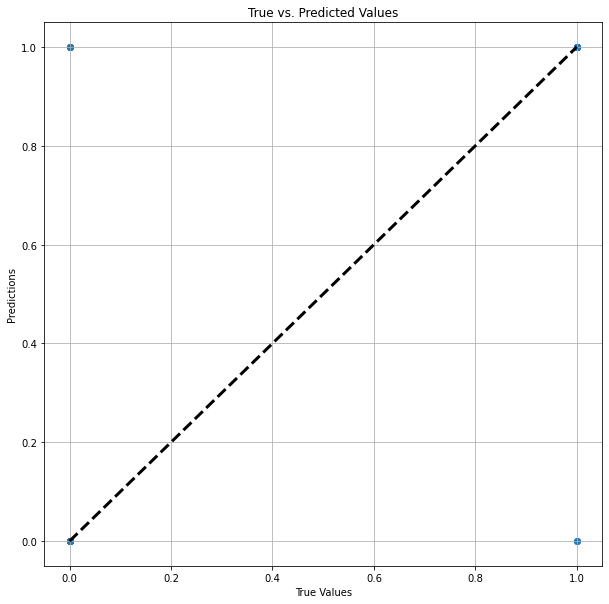

In [134]:
import matplotlib.pyplot as plt

# Get predictions on validation set
predictions = model.predict(X_val)

# Scatter plot
plt.figure(figsize=(10, 10))
plt.scatter(y_val, predictions, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=3)  # line of y=x for reference
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted Values')
plt.grid(True)
plt.show()


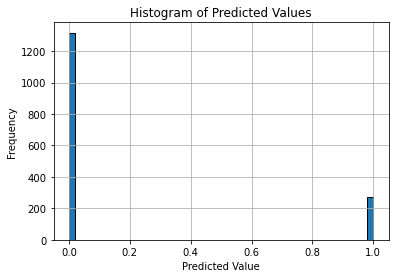

In [135]:
predicted_values = model.predict(X_val)

plt.hist(predicted_values, bins=50, edgecolor='k')
plt.xlabel('Predicted Value')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Values')
plt.grid(True)
plt.show()


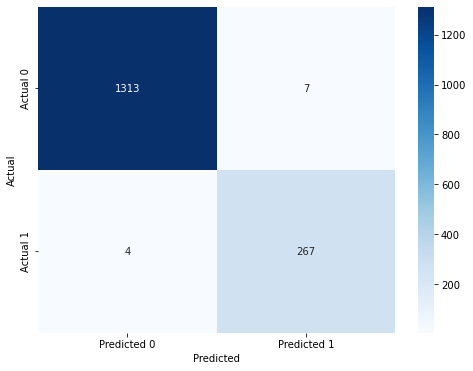

In [136]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
predicted_labels = (predicted_values > 0.5).astype(int)  # Convert values to binary predictions

cm = confusion_matrix(y_val, predicted_labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [123]:
tag = 11
#second train
tag = 28
train_feature,test_feature,train_label,test_label = \
    set_assigner(train_features[tag],test_features[tag],train_labels[tag],test_labels[tag])

In [124]:
X_train, X_val, y_train, y_val = train_test_split(test_feature, test_label, test_size=0.1)

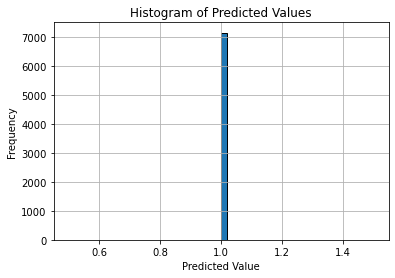

In [125]:
predicted_values = model.predict(X_train)

plt.hist(predicted_values, bins=50, edgecolor='k')
plt.xlabel('Predicted Value')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Values')
plt.grid(True)
plt.show()


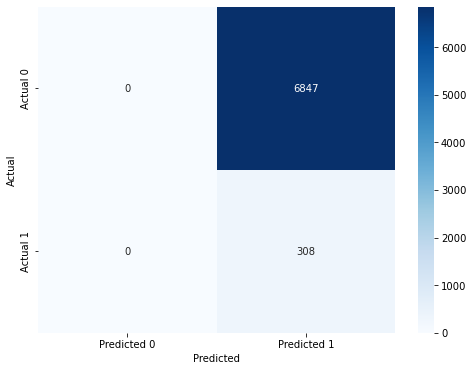

In [126]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
predicted_labels = (predicted_values > 0.5).astype(int)  # Convert values to binary predictions

cm = confusion_matrix(y_train, predicted_labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
